In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from mmd import mix_rbf_mmd2
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
class GNet(nn.Module):
    def __init__(self):
        super().__init__()
        model = nn.Sequential(
            nn.Linear(1, 7),
            nn.ELU(),
            nn.Linear(7, 13),
            nn.ELU(),
            nn.Linear(13, 7),
            nn.ELU(),
            nn.Linear(7, 1)
        )
        self.model = model
    def forward(self, input):
        return self.model(input)

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        model = nn.Sequential(
            nn.Linear(1, 11),
            nn.ELU(),
            nn.Linear(11, 29),
            nn.ELU()
        )
        self.model = model
    def forward(self, input):
        return self.model(input)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        model = nn.Sequential(
            nn.Linear(29, 11),
            nn.ELU(),
            nn.Linear(11, 1),
        )
        self.model = model
    def forward(self, input):
        return self.model(input)


In [3]:
def data_sampler(dist_type, dist_param, batch_size=1):
    if dist_type=="gaussian":
        return Tensor(np.random.normal(dist_param[0], dist_param[1], (batch_size, 1))).requires_grad_()
    elif dist_type=="uniform":
        return Tensor(np.random.uniform(dist_param[0], dist_param[1], (batch_size, 1))).requires_grad_()
    elif dist_type=="cauchy":
        return dist_param[1] * Tensor(np.random.standard_cauchy((batch_size, 1))) + 23.

In [4]:
num_iteration = 1000000
num_gen = 1
num_enc_dec = 5
lr = 1e-3
batch_size = 128
target_dist = "gaussian"
target_param = (23., 1.)

noise_dist = "gaussian"
noise_param = (0., 1.)

lambda_AE = 8.
# sigma for MMD
base = 1.0
sigma_list = [1, 2, 4, 8, 16]
sigma_list = [sigma / base for sigma in sigma_list]
print_int = 100


In [5]:
gen = GNet()
enc = Encoder()
dec = Decoder()
criterion = nn.MSELoss()
gen_optimizer = optim.Adam(gen.parameters(), lr=lr)
enc_optimizer = optim.Adam(enc.parameters(), lr=lr)
dec_optimizer = optim.Adam(dec.parameters(), lr=lr)
cum_dis_loss = 0
cum_gen_loss = 0

cum_dis_loss 0.29148088324815036, cum_gen_loss 0.2885611356422305


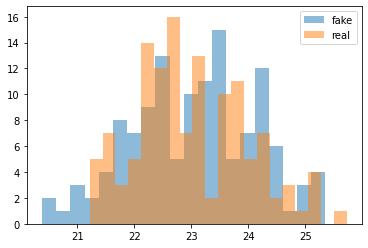

cum_dis_loss 0.1563829888999462, cum_gen_loss 0.1646688550338149


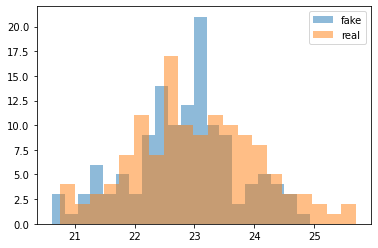

cum_dis_loss 0.15275468972325326, cum_gen_loss 0.15659425992518664


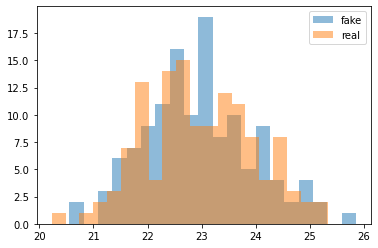

cum_dis_loss 0.1603007440790534, cum_gen_loss 0.17489632472395897


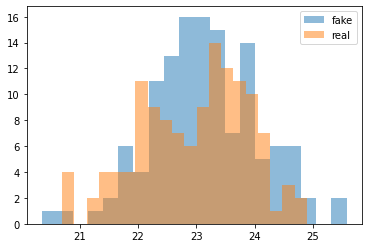

cum_dis_loss 0.15982852756232024, cum_gen_loss 0.16359714072197676


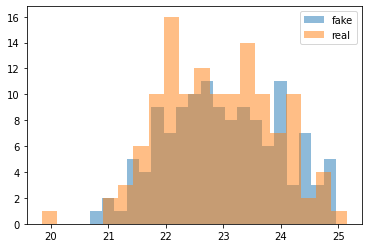

KeyboardInterrupt: 

In [13]:
for iteration in range(num_iteration):
    for i in range(num_enc_dec):
        enc.zero_grad()
        dec.zero_grad()
        target = data_sampler(target_dist, target_param, batch_size)
        noise = data_sampler(noise_dist, noise_param, batch_size)
        encoded_target = enc.forward(target)
        decoded_target = dec.forward(encoded_target)
        L2_AE_target = (target - decoded_target).pow(2).mean()
        transformed_noise = gen.forward(noise)
        encoded_noise = enc.forward(transformed_noise)
        decoded_noise = dec.forward(encoded_noise)
        L2_AE_noise = (transformed_noise - decoded_noise).pow(2).mean()
        MMD = mix_rbf_mmd2(encoded_target, encoded_noise, sigma_list)
        MMD = F.relu(MMD)
        L_MMD_AE = -1 * (torch.sqrt(MMD)-lambda_AE*(L2_AE_noise+L2_AE_target))
        L_MMD_AE.backward()
        enc_optimizer.step()
        dec_optimizer.step()
        cum_dis_loss = cum_dis_loss - L_MMD_AE.item()
    for i in range(num_gen):
        gen.zero_grad()
        target = data_sampler(target_dist, target_param, batch_size)
        noise = data_sampler(noise_dist, noise_param, batch_size)
        encoded_target = enc.forward(target)
        encoded_noise = enc.forward(gen.forward(noise))
        MMD = torch.sqrt(F.relu(mix_rbf_mmd2(encoded_target, encoded_noise, sigma_list)))
        MMD.backward()
        gen_optimizer.step()
        cum_gen_loss = cum_gen_loss + MMD.item()
    if iteration % print_int == 0 and iteration != 0:
        print('cum_dis_loss {}, cum_gen_loss {}'.format(cum_dis_loss/(print_int*num_enc_dec), cum_gen_loss/(print_int*num_gen)))
        cum_dis_loss = 0
        cum_gen_loss = 0
        target = data_sampler(target_dist, target_param, batch_size)
        target = target.data.numpy().reshape(batch_size)
        noise = data_sampler(noise_dist, noise_param, batch_size)
        transformed_noise = gen.forward(noise)
        transformed_noise = transformed_noise.data.numpy().reshape(batch_size)
        plt.hist(transformed_noise, 20, label='fake',alpha=0.5)

        plt.hist(target,20,label="real",alpha=0.5)
        plt.legend()
        plt.show()